# Knowledge Graphs for Complex Topics

# Introduction

**What is a knowledge graph?**

A knowledge graph, also known as a semantic network, represents real-world entities and their relationships. It consists of nodes, edges, and labels. Nodes can represent any entity, while edges define the connections between them. For example, a node representing an author like "J.K. Rowling" can be connected to another node representing one of her books, "Harry Potter", with the edge "author of".

**Applications of knowledge graphs**

Knowledge graphs have various applications, including:

-  Search Engines: They enhance search results by incorporating semantic-search information from diverse sources.
-  Recommendation Systems: They suggest products or services based on user behavior and preferences.
-  Natural Language Processing: They aid in understanding and generating human language.
-  Data Integration: They facilitate the integration of data from different sources by identifying relationships.
-  Artificial Intelligence and Machine Learning: They provide contextual information to improve decision-making.

----

## Setup and Dependencies

Today, we're going to use the [`instructor`](https://github.com/jxnl/instructor) library to simplify the interaction between OpenAI and our code. Along with [Graphviz](https://graphviz.org) library to bring structure to our intricate subjects and have a graph visualization.


In [2]:
import instructor 
from openai import OpenAI

client = instructor.patch(OpenAI())

Install the Graphviz based on your operation system https://graphviz.org/download/

## Node and Edge Classes

We begin by modeling our knowledge graph with Node and Edge objects.

Node objects represent key concepts or entities, while Edge objects signify the relationships between them.

In [3]:
from pydantic import BaseModel, Field
from typing import List, Optional

class Node(BaseModel):
    id: int
    label: str
    color: str

class Edge(BaseModel):
    source: int
    target: int
    label: str
    color: str = "black"

## `KnowledgeGraph` Class

The `KnowledgeGraph` class combines nodes and edges to create a comprehensive graph structure. It includes lists of nodes and edges, where each node represents a key concept or entity, and each edge represents a relationship between two nodes.

Later on, you'll see that we designed this class to match the graph object in the graphviz library, which makes it easier to visualize our graph.

The `visualize_knowledge_graph` function is used to visualize a knowledge graph. It takes a `KnowledgeGraph` object as input, which contains nodes and edges. The function utilizes the `graphviz` library to generate a directed graph (`Digraph`). Each node and edge from the `KnowledgeGraph` is added to the `Digraph` with their respective attributes (id, label, color). Finally, the graph is rendered and displayed.

In [4]:
from graphviz import Digraph
from IPython.display import display

class KnowledgeGraph(BaseModel):
    nodes: List[Node] = Field(..., default_factory=list)  # A list of nodes in the knowledge graph.
    edges: List[Edge] = Field(..., default_factory=list)  # A list of edges in the knowledge graph.


    def visualize_knowledge_graph(self):
        dot = Digraph(comment="Knowledge Graph")

        for node in self.nodes:
            dot.node(name=str(node.id), label=node.label, color=node.color)
        for edge in self.edges:
            dot.edge(str(edge.source), str(edge.target), label=edge.label, color=edge.color)
        
        return display(dot)


## Generating the Knowledge Graph

### generate_graph function

The ``generate_graph`` function uses OpenAI's model to create a KnowledgeGraph object from an input string.

It requests the model to interpret the input as a detailed knowledge graph and uses the response to form the KnowledgeGraph object.

In [8]:
def generate_graph(input) -> KnowledgeGraph:
    return client.chat.completions.create(
        model="gpt-4-1106-preview",
        messages=[
            {
                "role": "user",
                "content": f"Help me understand the following by describing it as small knowledge graph: {input}",
            }
        ],
        response_model=KnowledgeGraph,
    )

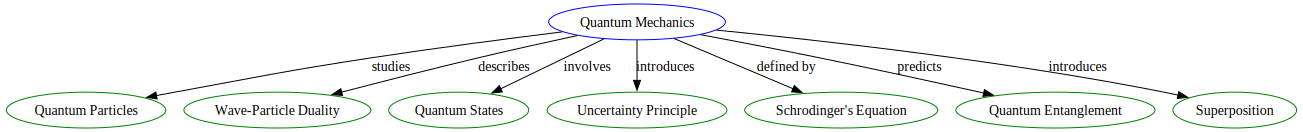

In [9]:
generate_graph("Explain quantum mechanics").visualize_knowledge_graph()

## Advanced: Accumulating Knowledge Graphs

When dealing with larger datasets, or knowledge that grows over time, processing them all at once can be challenging due to limitations in prompt length or the complexity of the content. In such cases, an iterative approach to building the knowledge graph can be beneficial. This method involves processing the text in smaller, manageable chunks and updating the graph with new information from each chunk.

### What are the benefits of this approach?

-  Scalability: This approach can handle large datasets by breaking them down into smaller, more manageable pieces.

-  Flexibility: It allows for dynamic updates to the graph, accommodating new information as it becomes available.

-  Efficiency: Processing smaller chunks of text can be more efficient and less prone to errors or omissions.

### What has changed?

The previous example provided a basic structure, while this new example introduces additional complexity and functionality. The Node and Edge classes now have a __hash__ method, allowing them to be used in sets and simplifying duplicate handling.

The KnowledgeGraph class has been enhanced with two new methods: ``update`` and ``draw``.

In the KnowledgeGraph class, the nodes and edges fields are now optional, offering greater flexibility.

The ``update`` method enables the merging and removal of duplicates from two graphs.

The ``draw`` method includes a prefix parameter, making it easier to create different graph versions during iterations.

In [10]:
class Node(BaseModel):
    id: int
    label: str
    color: str

    def __hash__(self) -> int:
        return hash((id, self.label))
    
class Edge(BaseModel):
    source: int
    target: int
    label: str
    color: str = "black"

    def __hash__(self) -> int:
        return hash((self.source, self.target, self.label))

In [11]:
class KnowledgeGraph(BaseModel):
    # Optional list of nodes and edges in the knowledge graph
    nodes: Optional[List[Node]] = Field(..., default_factory=list)
    edges: Optional[List[Edge]] = Field(..., default_factory=list)

    def update(self, other: "KnowledgeGraph") -> "KnowledgeGraph":
        # This method updates the current graph with the other graph, deduplicating nodes and edges.
        return KnowledgeGraph(
            nodes=list(set(self.nodes + other.nodes)),  # Combine and deduplicate nodes
            edges=list(set(self.edges + other.edges)),  # Combine and deduplicate edges
        )
    

    def visualize_knowledge_graph(self):
        dot = Digraph(comment="Knowledge Graph")

        for node in self.nodes:
            dot.node(str(node.id), node.label, color=node.color)
        for edge in self.edges:
            dot.edge(str(edge.source), str(edge.target), label=edge.label, color=edge.color)
        
        return display(dot)


### Generate iterative graphs

The updated `generate_graph` function is specifically designed to handle a list of inputs iteratively. It updates the graph with each new piece of information.

Upon closer inspection, this pattern resembles a common programming technique known as a "reduce" or "fold" function. A simple example of this would be iterating over a list to find the sum of all the elements squared.

Here's an example in Python:

```python
cur_state = 0
for i in [1, 2, 3, 4, 5]:
    cur_state += i**2
print(cur_state)
```

In [12]:
def generate_graph(input: List[str]) -> KnowledgeGraph:
    # Initialize an empty KnowledgeGraph
    cur_state = KnowledgeGraph()

    # Iterate over the input list
    for i, inp in enumerate(input):
        new_updates = client.chat.completions.create(
            model="gpt-4-1106-preview",
            messages=[
                {
                    "role": "system",
                    "content": """You are an iterative knowledge graph builder.
                    You are given the current state of the graph, and you must append the nodes and edges 
                    to it Do not procide any duplcates and try to reuse nodes as much as possible.""",
                },
                {
                    "role": "user",
                    "content": f"""Extract any new nodes and edges from the following:
                    # Part {i}/{len(input)} of the input:

                    {inp}""",
                },
                {
                    "role": "user",
                    "content": f"""Here is the current state of the graph:
                    {cur_state.model_dump_json(indent=2)}""",
                },
            ],
            response_model=KnowledgeGraph,
        )  # type: ignore

        # Update the current state with the new updates
        cur_state = cur_state.update(new_updates)

        # Draw the current state of the graph
        cur_state.visualize_knowledge_graph() 
        
    # Return the final state of the KnowledgeGraph
    return cur_state


### Examples Use Case

In this approach, we process the text in manageable chunks, one at a time.

This method is particularly beneficial when dealing with extensive text that may not fit into a single prompt.

It is especially useful in scenarios such as constructing a knowledge graph for a complex topic, where the information is distributed across multiple documents or sections.

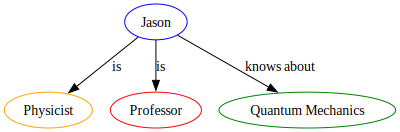

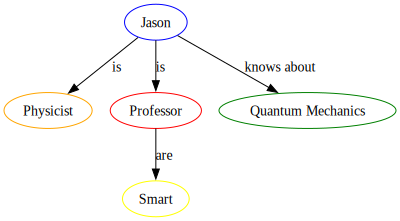

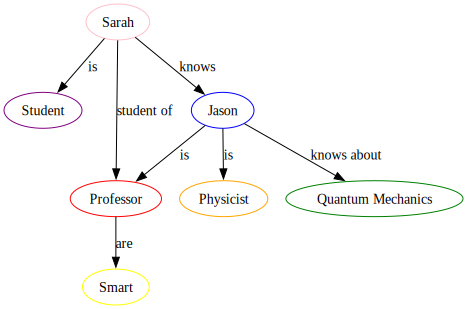

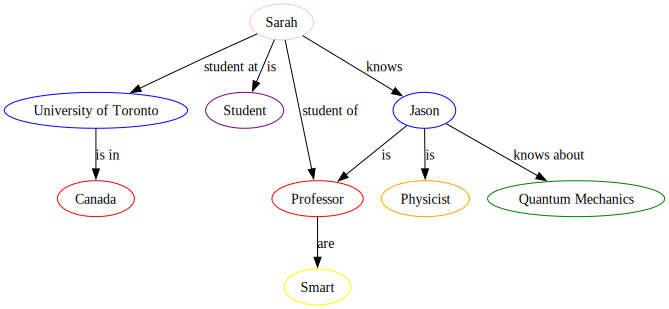

In [13]:
text_chunks = [
    "Jason knows a lot about quantum mechanics. He is a physicist. He is a professor",
    "Professors are smart.",
    "Sarah knows Jason and is a student of his.",
    "Sarah is a student at the University of Toronto. and UofT is in Canada.",
]

graph: KnowledgeGraph = generate_graph(text_chunks)

## Conclusion

This tutorial shows how to generate and visualize a knowledge graph for complex topics. It also demonstrates how to extract graphic knowledge from the language model or provided text. The tutorial highlights the iterative process of building the knowledge graph by processing text in smaller chunks and updating the graph with new information.

Using this approach, we can extract various things, including:

1) People and their relationships in a story.

```python
class People(BaseModel):
    id: str
    name: str
    description: str

class Relationship(BaseModel):
    id: str
    source: str
    target: str
    label: str
    description: str

class Story(BaseModel):
    people: List[People]
    relationships: List[Relationship]
```

2) Task dependencies and action items from a transcript.

```python
class Task(BaseModel):
    id: str
    name: str
    description: str

class Participant(BaseModel):
    id: str
    name: str
    description: str

class Assignment(BaseModel):
    id: str
    source: str
    target: str
    label: str
    description: str

class Transcript(BaseModel):
    tasks: List[Task]
    participants: List[Participant]
    assignments: List[Assignment]
```

3) Key concepts and their relationships from a research paper.
4) Entities and their relationships from a news article.

As an exercise, try to implement one of the above examples.

All of them will follow an idea of iteratively extracting more and more information and accumulating it into some state.